In [2]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


In [4]:
df = pd.read_csv('/content/Sentiment_analysis_Data.csv')
# df.head()

## Data Visualizalition

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

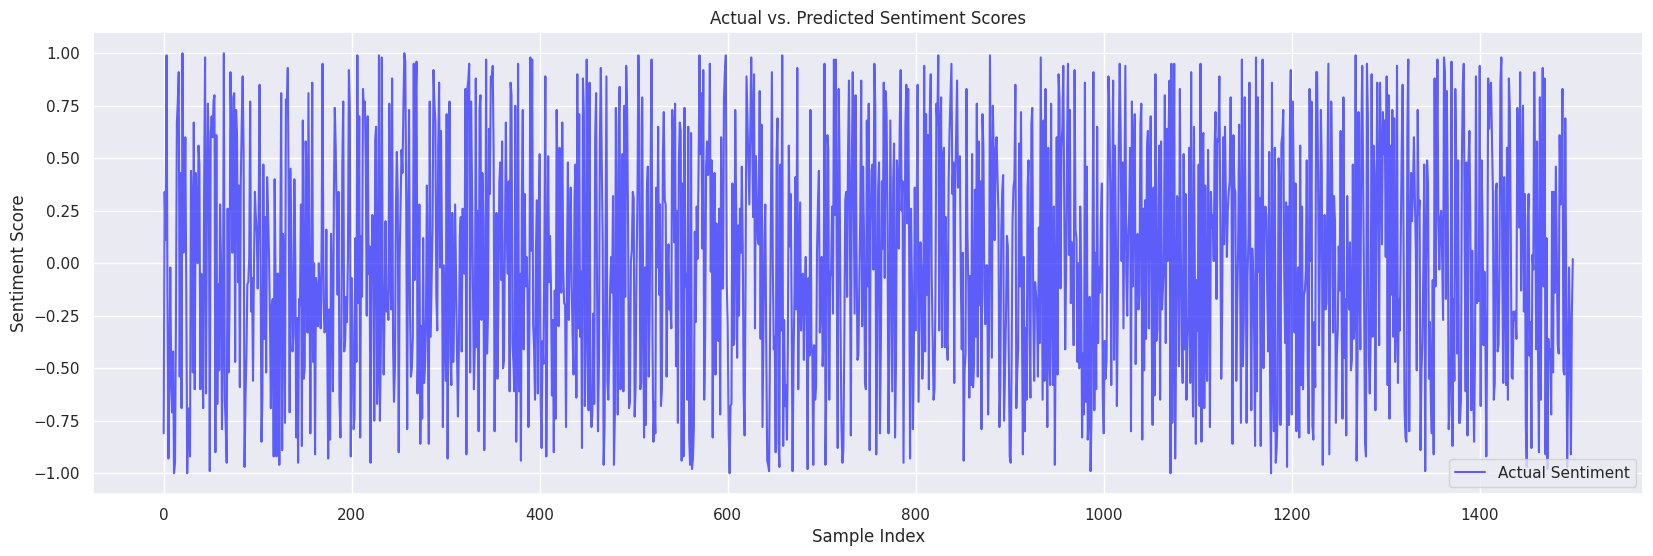

In [6]:

plt.figure(figsize=(20, 6))
plt.plot(df['sentiment_score'], color='blue', label='Actual Sentiment', alpha=0.6)

# Add labels, legend, and title
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.legend()
plt.show()

In [7]:
!pip install -q transformers

In [8]:
from transformers import AutoTokenizer

In [9]:

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [11]:
tokenize_function(df.head().to_dict('records')[0])


{'input_ids': [101, 5023, 9883, 2006, 10940, 2024, 2074, 16655, 23048, 2389, 999, 1001, 3361, 22779, 22648, 2100, 1001, 7325, 4783, 3270, 25500, 2099, 1001, 9874, 2075, 14399, 2594, 1024, 5166, 2075, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
df.head().to_dict('records')[0]

{'text': 'Hidden fees on loans are just unethical! #FinancialLiteracy #ConsumerBehavior #TrendingTopic: Budgeting',
 'sentiment_score': -0.81}

In [13]:
tokenized_list_dict = [tokenize_function(x) for x in df.to_dict('records')]

In [14]:
# tokenized_list_dict[:2]

In [15]:
# Convert the list of dictionaries into a DataFrame
new_data = pd.DataFrame(tokenized_list_dict)

# Concatenate the original DataFrame with the new tokenized DataFrame
df_new = pd.concat([df, new_data], axis=1)


In [16]:
df_new.head()

,text,sentiment_score,attention_mask,input_ids
0,Hidden fees on loans are just unethical! #Fina...,-0.81,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 5023, 9883, 2006, 10940, 2024, 2074, 166..."
1,Predatory loans are a trap—know the risks befo...,0.34,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 21659, 10940, 2024, 1037, 8132, 1517, 21..."
2,Did you know investing $100 monthly can grow t...,0.11,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2106, 2017, 2113, 19920, 1002, 2531, 705..."
3,"Surprisingly, budgeting apps can save up to 20...",0.99,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 10889, 1010, 5166, 2075, 18726, 2064, 38..."
4,Imagine achieving financial independence by 40...,-0.14,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 5674, 10910, 3361, 4336, 2011, 2871, 999..."


In [17]:
df_new.columns

Index(['text', 'sentiment_score', 'attention_mask', 'input_ids'], dtype='object')

In [19]:
from transformers import AutoModelForSequenceClassification
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda')

In [21]:

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=1).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  mse = mean_squared_error(labels, preds)
  mae = mean_absolute_error(labels, preds)
  r2 = r2_score(labels, preds)
  return {"mse": mse, "mae": mae, "r2": r2}

In [23]:
from huggingface_hub import notebook_login

notebook_login()

In [24]:
from transformers import TrainingArguments, Trainer

In [25]:
training_args = TrainingArguments(output_dir="fine_tune_sentiment_analysis_fin",
                                  num_train_epochs=30,
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=True)

In [26]:
# help(TrainingArguments)

In [27]:
df_new.rename(columns={'sentiment_score': 'label'}, inplace=True)
df_new = df_new.sample(frac=1).reset_index(drop=True)

# Define the split sizes
train_size = 0.8
test_size = 0.1
eval_size = 0.1

# Calculate the split indices
train_end = int(train_size * len(df))
test_end = int((train_size + test_size) * len(df))

# Split the DataFrame
train_df = df_new[:train_end]
test_df = df_new[train_end:test_end]
eval_df = df_new[test_end:]


In [28]:
print("Training Set:")
print(train_df.size)
print("\nTest Set:")
print(test_df.size)
print("\nEvaluation Set:")
print(eval_df.size)

Training Set:
4800

Test Set:
600

Evaluation Set:
600


In [29]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_df.to_dict('records'),
                  eval_dataset=eval_df.to_dict('records'),
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer)

<ipython-input-29-0ae3e1f864e5>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


In [30]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Mse,Mae,R2
1,No log,0.360360,0.357406,0.523133,-0.000030
2,No log,0.365444,0.357406,0.523133,-0.000030
3,No log,0.371298,0.357406,0.523133,-0.000030
4,No log,0.379939,0.357406,0.523133,-0.000030
5,No log,0.379607,0.357406,0.523133,-0.000030
6,No log,0.392484,0.357406,0.523133,-0.000030
7,No log,0.379271,0.357406,0.523133,-0.000030
8,No log,0.399349,0.357406,0.523133,-0.000030
9,No log,0.395696,0.357406,0.523133,-0.000030
10,No log,0.405103,0.357406,0.523133,-0.000030


TrainOutput(global_step=570, training_loss=0.2797985913460715, metrics={'train_runtime': 182.9718, 'train_samples_per_second': 196.752, 'train_steps_per_second': 3.115, 'total_flos': 438558618890496.0, 'train_loss': 0.2797985913460715, 'epoch': 30.0})

In [31]:
trainer.push_to_hub(commit_message="Training complete")

CommitInfo(commit_url='https://huggingface.co/abbysAI/fine_tune_sentiment_analysis_fin/commit/0ac948888c9c2c1fe1910caae273b387b9ebcb49', commit_message='Training complete', commit_description='', oid='0ac948888c9c2c1fe1910caae273b387b9ebcb49', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abbysAI/fine_tune_sentiment_analysis_fin', endpoint='https://huggingface.co', repo_type='model', repo_id='abbysAI/fine_tune_sentiment_analysis_fin'), pr_revision=None, pr_num=None)

In [32]:
from transformers import pipeline

classifier  = pipeline('sentiment-analysis', model='abbysAI/fine_tune_sentiment_analysis_fin')


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [34]:
classifier("Apple's AI is liked by its most customers")

[{'label': 'LABEL_0', 'score': -0.08228760212659836}]

In [35]:
classifier( test_df['text'].values.tolist()) # test_df['text'].apply(lambda x: classifier(x)[0])

[{'label': 'LABEL_0', 'score': -0.3863915503025055},
 {'label': 'LABEL_0', 'score': 0.2826688587665558},
 {'label': 'LABEL_0', 'score': -0.5806372761726379},
 {'label': 'LABEL_0', 'score': -0.345400869846344},
 {'label': 'LABEL_0', 'score': 0.0034331893548369408},
 {'label': 'LABEL_0', 'score': 0.2508186995983124},
 {'label': 'LABEL_0', 'score': -0.015252317301928997},
 {'label': 'LABEL_0', 'score': 0.05930884927511215},
 {'label': 'LABEL_0', 'score': 0.31946349143981934},
 {'label': 'LABEL_0', 'score': -0.10680894553661346},
 {'label': 'LABEL_0', 'score': 0.2914785146713257},
 {'label': 'LABEL_0', 'score': 0.46474942564964294},
 {'label': 'LABEL_0', 'score': -0.07268945127725601},
 {'label': 'LABEL_0', 'score': -0.1036742627620697},
 {'label': 'LABEL_0', 'score': 0.14750973880290985},
 {'label': 'LABEL_0', 'score': -0.492017537355423},
 {'label': 'LABEL_0', 'score': -0.3777148425579071},
 {'label': 'LABEL_0', 'score': -0.16681474447250366},
 {'label': 'LABEL_0', 'score': 0.24912734329

In [36]:
test_df.head()

,text,label,attention_mask,input_ids
1200,Did you know investing $100 monthly can grow t...,-0.71,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2106, 2017, 2113, 19920, 1002, 2531, 705..."
1201,I’m working on balancing my budget while savin...,-0.20,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 1521, 1049, 2551, 2006, 20120, 202..."
1202,Unexpected expenses can shake even the best fi...,-0.79,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 9223, 11727, 2064, 6073, 2130, 1996, 219..."
1203,Diversifying my investments has given me both ...,-0.53,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 18612, 11787, 2026, 10518, 2038, 2445, 2..."
1204,Overspending on credit cards leads to long-ter...,0.09,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 15849, 11837, 4667, 2006, 4923, 5329, 52..."


In [37]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [60]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import numpy as np

# Load the dataset (you can replace with your dataset)
# dataset = load_dataset("imdb")
dataset = Dataset.from_pandas(pd.read_csv('/content/Sentiment_analysis_Data.csv'))
print(dataset.column_names)
dataset = dataset.rename_column("sentiment_score", "label")
dataset.column_names

['text', 'sentiment_score']


['text', 'label']

In [61]:


# Normalize the labels to range from -1 to 1 for regression
def normalize_labels(example):
    example['label'] = 2 * (example['label'] - 0.5)  # Map 0 to -1 and 1 to +1
    return example

dataset = dataset.map(normalize_labels)

# Load pre-trained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Single output for regression


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:

# Split the dataset into training and testing sets
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [66]:
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
})

In [67]:

# Preprocess the data: tokenize the text
def preprocess_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length')

tokenized_data = train_test_dataset.map(preprocess_function, batched=True)
tokenized_data = tokenized_data.remove_columns(['text'])  # Remove unused columns
tokenized_data = tokenized_data.rename_column("label", "labels")  # Rename 'label' column to 'labels'



Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [56]:
# dataset['label']


In [70]:

# Define the evaluation metric (e.g., Mean Squared Error)
# mse_metric = evaluate.load("mean_squared_error")

def compute_metrics(eval_pred):
    print(type(eval_pred))
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids

    # For regression, flatten the predictions
    predictions = predictions.flatten()

    # Compute MSE
    mse = mean_squared_error(labels, predictions)
    return {"mse": mse}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Test the model on an example sentence
example_text = "I absolutely love this movie! It's so inspiring and well-made."
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
polarity = outputs.logits.item()  # Extract the regression score

print(f"Predicted Sentiment Polarity: {polarity}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-70-83d70cee844c>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mse
1,1.549700,1.547805,1.547805
2,1.191400,1.373769,1.373769
3,1.100000,1.434885,1.434885


<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [71]:
# Train the model
trainer.push_to_hub(commit_message="Training complete")

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/abbysAI/results/commit/1c4664e57d304255f0be47286c69271e0c25bd25', commit_message='Training complete', commit_description='', oid='1c4664e57d304255f0be47286c69271e0c25bd25', pr_url=None, repo_url=RepoUrl('https://huggingface.co/abbysAI/results', endpoint='https://huggingface.co', repo_type='model', repo_id='abbysAI/results'), pr_revision=None, pr_num=None)

In [1]:
# dataset['train'][5:]

In [72]:


classifier_bbu  = pipeline('sentiment-analysis', model='abbysAI/results')

config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [75]:
classifier_bbu("Apple Intelligence is not liked by its most customers")

[{'label': 'LABEL_0', 'score': -0.8504511713981628}]